# Projet Optimisation - Partie 2
---

## Imports

In [1]:
import sys
import json # To store solutions
import numpy as np
np.set_printoptions(threshold=sys.maxsize) # To print more elements of an array in terminal
import pandas as pd
from scipy.optimize import linprog
import matplotlib.pyplot as plt

# For modelising more complex problems
import cvxpy as cp

## Datas

In [2]:
# Loads dataframe
sites_df = pd.read_csv('Data-partie-2/Sites.csv')
offshore_df = pd.read_csv('Data-partie-2/Rendements_offshore.csv', header=None).to_numpy()
onshore_df = pd.read_csv('Data-partie-2/Rendements_onshore.csv', header=None).to_numpy()

# Get index of onshore and offshore sites and convert to numpy array
offshore_idx = sites_df[sites_df['capacite offshore'] == 'Oui']['index site'].to_numpy(dtype=int)
onshore_idx = sites_df[sites_df['capacite offshore'] == 'Non']['index site'].to_numpy(dtype=int)

# Get number of sites (n) and number of hours in a year (m)
n = sites_df.shape[0]
m = offshore_df.shape[1]

# Get max capacity of offshore and onshore sites
max_capacity = np.zeros(n)
max_capacity[offshore_idx] = sites_df[sites_df['capacite offshore'] == 'Oui']['capacites'].to_numpy(dtype=float)
max_capacity[onshore_idx] = sites_df[sites_df['capacite offshore'] == 'Non']['capacites'].to_numpy(dtype=float)

# Filter offshore and onshore dataframes
offshore_df = offshore_df[offshore_idx, :]
onshore_df = onshore_df[onshore_idx, :]
rendements_on_off = np.zeros((n, m)) # Matrix that contains all the rendements of onshore and offshore sites at the correct indices
rendements_on_off[offshore_idx, :] = offshore_df
rendements_on_off[onshore_idx, :] = onshore_df
rendements_on_off_3 = np.zeros((n,m//3))
for k in range(rendements_on_off.shape[0]): # Regroup by 3 hours
    rendements_on_off_3[k] = np.sum(rendements_on_off[k].reshape(-1,3), axis = 1)


# Loads consumption and hydro production
consumptions = np.sum(pd.read_csv('Data-partie-2/Consommations.csv', header=None).to_numpy(), axis = 0)
consumptions_3 = np.sum(consumptions.reshape(-1,3),axis = 1) # Regroup by 3 hours
hydro_productions = np.sum(pd.read_csv('Data-partie-2/Apports-hydro.csv', header=None).to_numpy(), axis = 0) 
hydro_productions_3 = np.sum(hydro_productions.reshape(-1,3),axis = 1) # Regroup by 3 hours

# Costs
onshore_install_cost = 168903 # [euro/MWh/year]
offshore_install_cost = 300336 # [euro/MWh/year]

gaz_install_cost = 94956 # [euro/MW/year]
gaz_production_cost = 65 # [euro/MWh]

# Country max stock per country [MWh]
max_stock = np.sum(np.array([0.3*1e6 , 3.2*1e6 , 0.01*1e6 , 0 , 18.4*1e6 , 9.8*1e6 , 0.24*1e6 , 7.9*1e6 , 0.005*1e6 , 84.147*1e6 , 0 , 2.6*1e6 , 1.2*1e6 , 33.756*1e6 , 8.4*1e6]))

# Max turbine and pump power per country [MW] 
max_turbine_power = np.sum(np.array([8587 , 12009 , 1417 , 9 , 18372 , 25132 , 527 , 21117 , 1140 , 28941 , 37 , 5052 , 4269 , 16637 , 15101]))*3
max_pump_power = np.sum(np.array([5223 , 3580 , 1307 , 0 , 5347 , 4303 , 292 , 7544 , 1100 , 1396 , 0 , 1029 , 2744 , 45 , 1636 ]))*3

# Turbine efficiency (eta)
turbine_efficiency = 0.85

m = 2920 # Number of periods of 3 hours

## Question 4B
# Variables de décision
$$
\begin{align*} 
c_i = \text{Capacité éolienne installée sur le site i} \quad \forall i \in \{0, \ldots, 641 \} \implies c \in \mathbb{R}^{642} \\
t_j = \text{Puissance de turbinage à la période j} \quad \forall j \in \{0, \ldots, 2919\} \implies t \in \mathbb{R}^{2920}\\
p_j = \text{Puissance de pompage à la période j} \quad \forall j \in \{0, \ldots, 2919 \} \implies p \in \mathbb{R}^{2920}
\end{align*}
$$
# Problème à résoudre
$$
\begin{align*}
\min_{c, t, p} \frac{\sum_{offshore} c_i*300336 + \sum_{onshore} c_i * 168903}{2920} \\
\text{tel que} \\
\text{(Capacité éolienne entre 0 et son max)} \quad &0 \leq c_i \leq c_i^{max}  \quad \forall i \in \{0, \ldots, 641 \} \\
\text{(Le besoin de consommation est satisfait)} \quad &\sum_{i = 0}^{641} c_i e_i(j) + 0.85*t_j - p_j \geq cons_j \quad \forall j \in \{0, \ldots, 2919\} \\
\text{(Physique du bassin, de base à 0.5 de capacité tot au début de la première période)} \quad & 0 \leq \frac{max\_stock}{2} + \sum_{i = 0}^{j} \left(p_i - t_i + a_i \right) \leq max\_stock \quad \forall j \in \{0, \ldots, 2918\} \\
\text{(Contrainte de bilan nul du bassin)} \quad &\sum_{i = 0}^{2919} p_i - t_i + a_i = 0 \\
\text{(Contrainte de turbinage)} \quad &0 \leq t_j \leq max\_turbinage \quad \forall j \in \{0, \ldots, 2919\} \\
\text{(Contrainte de pompage)} \quad &0 \leq p_j \leq max\_pompage \quad \forall j \in \{0, \ldots, 2919\}

\end{align*}
$$

In [4]:
# Variable vectors
c = cp.Variable(n)
t = cp.Variable(m)
p = cp.Variable(m)

# Objective function
costs = np.zeros(n)
costs[onshore_idx] = onshore_install_cost
costs[offshore_idx] = offshore_install_cost
f = cp.Minimize(costs.T@c/(m))

constraints = [
    c >= 0,
    c <= max_capacity,
    c@rendements_on_off_3[:, 0:m] + 0.85*t - p >= consumptions_3[0:m],
    0.5*max_stock + np.tri(m-1)@p[:-1] - np.tri(m-1)@t[:-1] + np.tri(m-1)@hydro_productions_3[0:m][:-1] <= max_stock,
    0.5*max_stock + np.tri(m-1)@p[:-1] - np.tri(m-1)@t[:-1] + np.tri(m-1)@hydro_productions_3[0:m][:-1] >= 0,
    np.ones(m)@p - np.ones(m)@t + np.ones(m)@hydro_productions_3[0:m] == 0,
    p >= 0,
    p <= max_pump_power,
    t >= 0,
    t <= max_turbine_power
]
problem = cp.Problem(f, constraints)

problem.solve(solver=cp.CLARABEL)
print(problem.status)
print(problem.value)


optimal
67947438.96239576


AttributeError: 'float' object has no attribute 'tolist'

In [9]:
# Dual values of the constraints (Each row corresponds to a constraint and can be a float or an array)
dual_values = []
for constraint in problem.constraints:
    if type(constraint.dual_value) == float:
        dual_values.append(constraint.dual_value)
    else:
        dual_values.append(constraint.dual_value.tolist())

# Save the solution
dic = {
    'optimum': problem.value,
    'c': c.value.tolist(),
    't': t.value.tolist(),
    'p': p.value.tolist(),
    'dual_values': dual_values
}

json_object = json.dumps(dic, indent = 4)

with open('solutions/sol4B_All.json', 'w') as f:
    f.write(json_object)

In [49]:
solc = np.array(c.value)

In [50]:
soltp = np.stack((t.value, p.value))

In [51]:
np.save("solutions/sol4B_C.npy", solc)
np.save("solutions/sol4B_TP.npy", soltp)

In [2]:
tot_cost = 67947438.96239851*2920
print(tot_cost)

198406521770.20367


In [7]:
tot_cost / np.sum(consumptions_3) #€/MWh

76.59960056819827

In [70]:
Turbinage = np.load("solutions/sol4B_TP.npy")[0]
Pompage = np.load("solutions/sol4B_TP.npy")[1]

In [13]:
from matplotlib.ticker import MaxNLocator

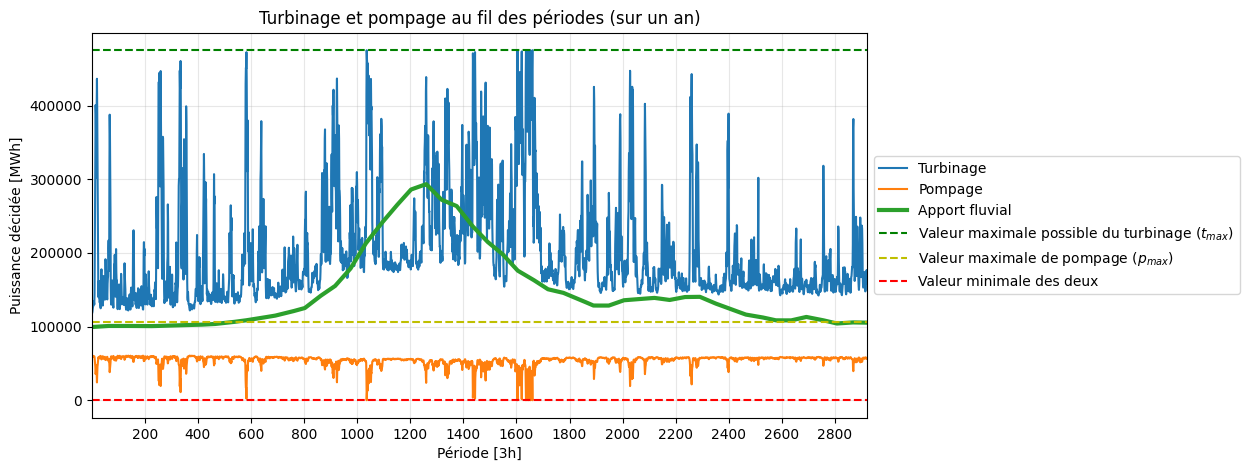

In [72]:
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Turbinage et pompage au fil des périodes (sur un an)')
plt.plot(t, Turbinage, label='Turbinage')
plt.plot(t, Pompage, label='Pompage')
plt.plot(t, hydro_productions_3, label='Apport fluvial', linewidth=3)
plt.xlabel('Période [3h]')
plt.ylabel('Puissance décidée [MWh]')
plt.xlim(1,2920)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.grid(alpha=0.3)
plt.axhline(y=max_turbine_power, color='g', linestyle='--', label='Valeur maximale possible du turbinage ($t_{max}$)')
plt.axhline(y=max_pump_power, color = "y", linestyle='--', label='Valeur maximale de pompage ($p_{max}$)')
plt.axhline(y=0, color='r', linestyle='--', label='Valeur minimale des deux')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('rapport/GraphesP2/Turbinage_pompage_Q4.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

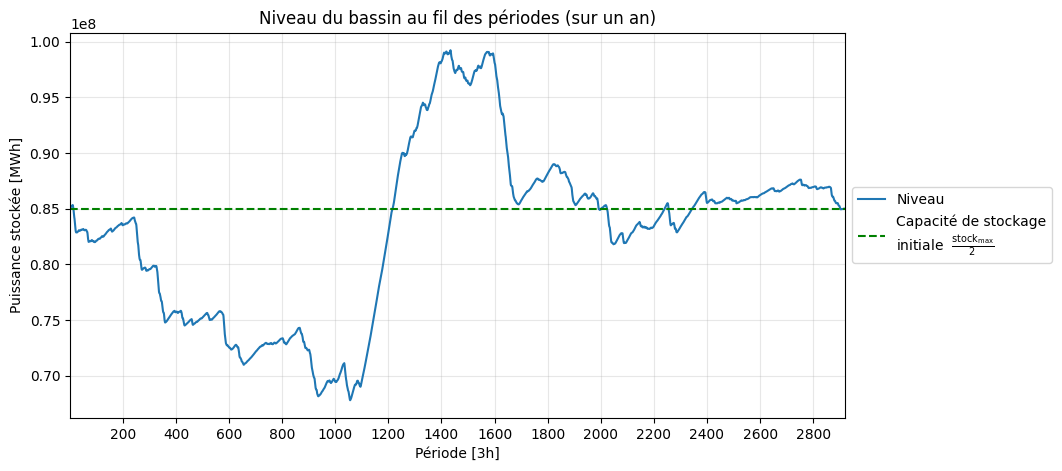

In [73]:
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Niveau du bassin au fil des périodes (sur un an)')
plt.plot(t, max_stock/2 + np.tri(2920)@Pompage - np.tri(2920)@Turbinage + np.tri(2920)@hydro_productions_3, label='Niveau')
plt.xlabel('Période [3h]')
plt.ylabel('Puissance stockée [MWh]')
plt.xlim(1,2920)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.grid(alpha=0.3)
plt.axhline(y=max_stock/2, color='g', linestyle='--', label='Capacité de stockage\n'  + r"initiale  $\frac{\mathrm{stock}_\mathrm{max}}{2}$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('rapport/GraphesP2/Niveau_Bassin_Q4.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

In [74]:
ChoixEolien = np.load("solutions/sol4B_C.npy")

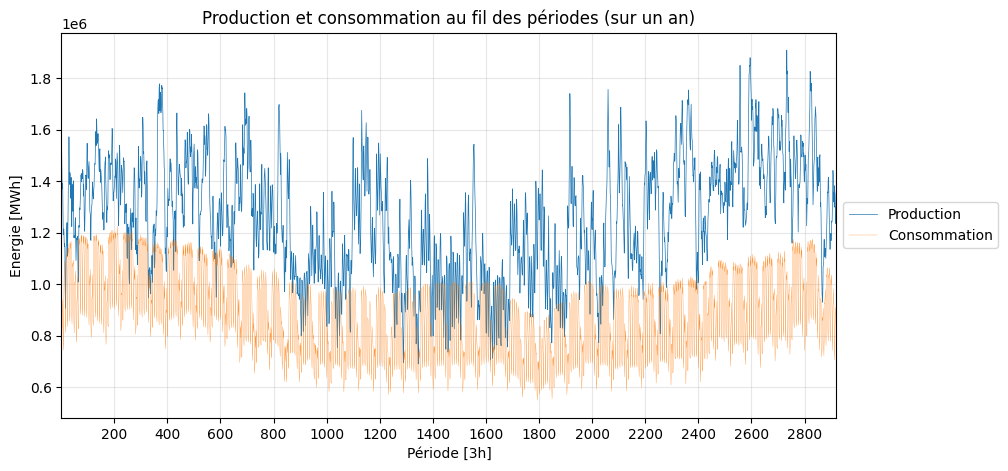

In [75]:
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Production et consommation au fil des périodes (sur un an)')
plt.plot(ChoixEolien@rendements_on_off_3 + 0.85*Turbinage - Pompage, label='Production', linewidth = 0.5)
plt.plot(consumptions_3, label='Consommation', linewidth = 0.2)
plt.xlabel('Période [3h]')
plt.ylabel('Energie [MWh]')
plt.xlim(1,2920)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.grid(alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('rapport/GraphesP2/Prod_Cons_Q4.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

In [15]:
max(Pompage)

60971.462590616604

## Question 5

In [5]:
m = 2920

In [6]:
# Variable vectors
c = cp.Variable(n, integer = True)
t = cp.Variable(m)
p = cp.Variable(m)

# Objective function
costs = np.zeros(n)
costs[onshore_idx] = onshore_install_cost
costs[offshore_idx] = offshore_install_cost
f = cp.Minimize(costs.T@(0.5*cp.multiply(c, max_capacity)))

constraints = [
    (0.5*cp.multiply(c, max_capacity))@rendements_on_off_3[:, 0:m] + 0.85*t - p >= consumptions_3[0:m],
    0.5*max_stock + np.tri(m-1)@p[:-1] - np.tri(m-1)@t[:-1] + np.tri(m-1)@hydro_productions_3[0:m][:-1] <= max_stock,
    0.5*max_stock + np.tri(m-1)@p[:-1] - np.tri(m-1)@t[:-1] + np.tri(m-1)@hydro_productions_3[0:m][:-1] >= 0,
    np.ones(m)@p - np.ones(m)@t + np.ones(m)@hydro_productions_3[0:m] == 0,
    c >= 0,
    c <= 2,
    p >= 0,
    p <= max_pump_power,
    t >= 0,
    t <= max_turbine_power,
]
problem = cp.Problem(f, constraints)

problem.solve()
print(problem.status)
print(problem.value)
#Coût total

optimal
198455604209.2905


In [7]:
198461771524.1526/np.sum(consumptions_3)

76.62093106200572

In [8]:
soltp = np.stack((t.value, p.value))
np.save("solutions/sol5_C.npy", c.value)
np.save("solutions/sol5_TP.npy", soltp)

In [9]:
# Save the solution
dic = {
    'optimum': problem.value,
    'c': c.value.tolist(),
    't': t.value.tolist(),
    'p': p.value.tolist(),
}

json_object = json.dumps(dic, indent = 4)

with open('solutions/sol5_All.json', 'w') as f:
    f.write(json_object)

In [10]:
np.sum(consumptions_3)

2590176976.1000004

In [11]:
Turbinage = np.load("solutions/sol5_TP.npy")[0]
Pompage = np.load("solutions/sol5_TP.npy")[1]

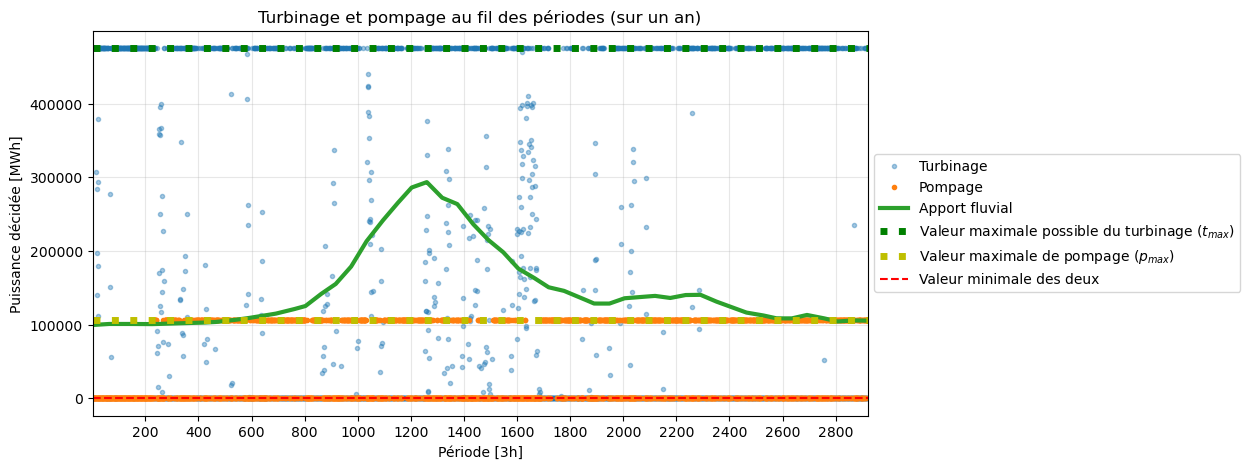

In [14]:
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Turbinage et pompage au fil des périodes (sur un an)')
plt.plot(t, Turbinage, '.', label='Turbinage', alpha = 0.4)
plt.plot(t, Pompage, '.', label='Pompage')
plt.plot(t, hydro_productions_3, label='Apport fluvial', linewidth=3)
plt.xlabel('Période [3h]')
plt.ylabel('Puissance décidée [MWh]')
plt.xlim(1,2920)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.grid(alpha=0.3)
plt.axhline(y=max_turbine_power, color='g', linestyle=':', label='Valeur maximale possible du turbinage ($t_{max}$)', linewidth =5)
plt.axhline(y=max_pump_power, color = "y", linestyle=':', label='Valeur maximale de pompage ($p_{max}$)', linewidth =5)
plt.axhline(y=0, color='r', linestyle='--', label='Valeur minimale des deux')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('rapport/GraphesP2/Turbinage_pompage_Q5.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

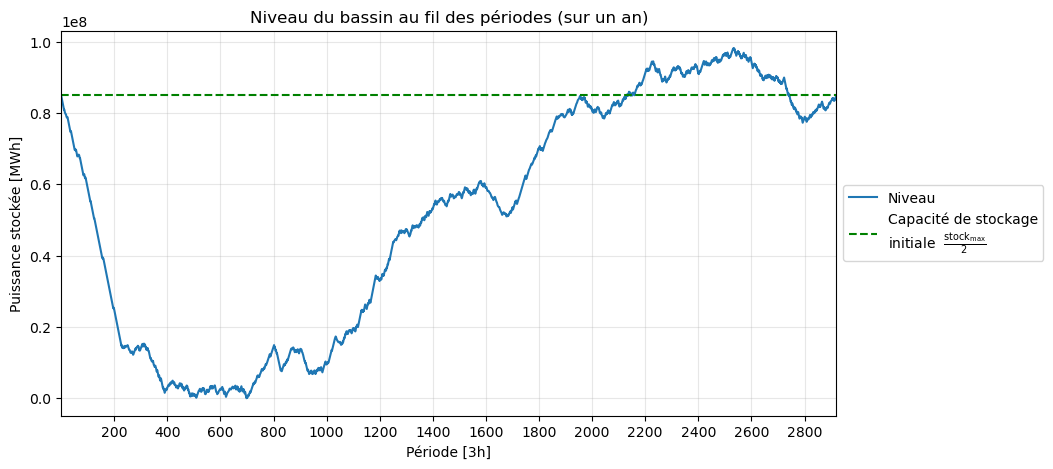

In [15]:
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Niveau du bassin au fil des périodes (sur un an)')
plt.plot(t, max_stock/2 + np.tri(2920)@Pompage - np.tri(2920)@Turbinage + np.tri(2920)@hydro_productions_3, label='Niveau')
plt.xlabel('Période [3h]')
plt.ylabel('Puissance stockée [MWh]')
plt.xlim(1,2920)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.grid(alpha=0.3)
plt.axhline(y=max_stock/2, color='g', linestyle='--', label='Capacité de stockage\n'  + r"initiale  $\frac{\mathrm{stock}_\mathrm{max}}{2}$")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('rapport/GraphesP2/Niveau_Bassin_Q5.pdf', format='pdf', bbox_inches='tight', pad_inches=0)

In [17]:
c = np.load("solutions/sol5_C.npy")
ChoixCombinés = np.array(c)
ChoixCombinés *= 0.5
Unique, Compte = np.unique(ChoixCombinés, return_counts=True)

dict(zip(Unique, Compte))

{-0.0: 211, 0.5: 8, 1.0: 423}

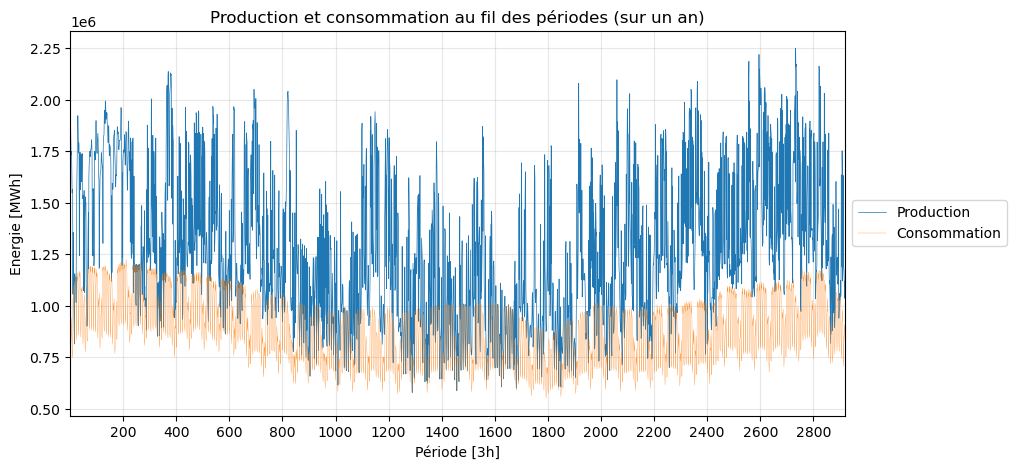

In [18]:
t = np.arange(1, m+1)
fig = plt.figure(figsize=(10, 5))
plt.title('Production et consommation au fil des périodes (sur un an)')
plt.plot((ChoixCombinés*max_capacity)@rendements_on_off_3 + 0.85*Turbinage - Pompage, label='Production', linewidth = 0.5)
plt.plot(consumptions_3, label='Consommation', linewidth = 0.2)
plt.xlabel('Période [3h]')
plt.ylabel('Energie [MWh]')
plt.xlim(1,2920)
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=15))
plt.grid(alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.savefig('rapport/GraphesP2/Prod_Cons_Q5.pdf', format='pdf', bbox_inches='tight', pad_inches=0)